ML2 Spiking Network Exercise with PyNN & NEST
==============

In this exercise, we will use PyNN & NEST to learn visual event-based features with STDP.
We will use python 3.

    
Tools
--------

NEST is a popular spiking neural network simulator. 
PyNN is a wrapper around nest, and other neural network simulator (including neuromorphic hardware).


Installation
-------------

If you work in a python virtual environment you do not need the **--user** option, but make sure you are running this jupyter notebook with the environment activated.

### nest

Install the [latest version of nest](https://nest-simulator.readthedocs.io/en/stable/installation/).
If you are on ubuntu/debian, it is just an apt-get install.

Make sure the installation worked with the following command:
```bash
python3 -c "import nest; print(nest.version())"
```

### pyNN

Install pyNN with pip:
```bash
pip3 install pyNN --user --upgrade
```

Make sure the installation worked with the following command:
```bash
python3 -c "import pyNN; print(pyNN.__version__)"
```

### imageio

This is a library for image loading images:

```bash
pip3 install imageio --user --upgrade
```

### jupyter widgets

To have UI interactions from jupyter notebook:

```bash
pip3 install ipywidgets
jupyter nbextension enable --py widgetsnbextension
```


# Make sure you can import everything we need

After you have run the installation steps, you need to:
- restart the kernel of this jupyter notebook (**kernel** -> **restart** in the menu bar above).
- reload this page (F5) to activate the sliders

In [1]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [2]:
import pyNN.nest as sim
import numpy as np
from imageio import imread
from matplotlib import animation 
import matplotlib.pyplot as plt
from IPython.display import HTML
sim.setup()

CSAConnector: libneurosim support not available in NEST.
Falling back on PyNN's default CSAConnector.
Please re-compile NEST using --with-libneurosim=PATH


/home/jkaiser/.local/lib/python3.6/site-packages/pyNN/nest/__init__.py:53: UserWarning:Unable to install NEST extensions. Certain models may not be available.
/usr/lib/python3.6/dist-packages/nest/lib/hl_api_helper.py:127: UserWarning:
ResetNetwork is deprecated and will be removed in NEST 3.0.


0

In [3]:
import IPython.display
import numpy as np
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets


-------------------------


# Introduction to the exercise

In this exercise, we will learn visual features over some samples of the MNIST dataset with spiking neural network.
The features will be learned in an unsupervised way with STDP.
By following this exercise, you will have fun & rehearse:
* The STDP learning rule
* Winner-take-all
* Encoding visual stimuli

By exploring a little further, you can also experiment by yourself:
* Dendritic delays
* Assossiative learning
* Dropouts (stochastic synapses)
* Noise
* ...

In the whole exercise, we have a feedforward 2-layers network (input and output).
The whole exercise is similar to __P. U. Diehl and M. Cook, “Unsupervised learning of digit recognition using spike-timing-dependent plasticity.,” Front. Comput. Neurosci., vol. 9, no. August, p. 99, 2015.__

## We load our stimuli: some MNIST samples


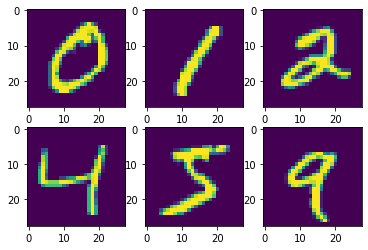

In [4]:
%matplotlib inline
fig, axes = plt.subplots(2,3)

stimuli_filenames = [
    "m0.png",
    "m1.png",
    "m2.png",
    "m4.png",
    "m5.png",
    "m9.png"
]

stimuli = [ imread('images/'+stimulus) for stimulus in stimuli_filenames]
for ii, stimulus in enumerate(stimuli):
    ax = plt.subplot(2,3,ii+1)
    ax.imshow(stimulus)
input_shape = stimuli[0].shape

## We define some utility functions

* __simulate_network()__: set the stimuli one by one to the input neurons and simulate with pauses inbetween
* __create_network()__: create input and output population; but **do not create the connection: this is your job!**
* __plot_spiketrain()__: plot the spiketrain of the output neurons with the lines indicating the stimuli
* __plot_weights()__: plot the weights of the projection assuming an array of shape input_shape

In [5]:
%matplotlib inline
stim_exposure = 500
epsilon = 1
max_rate = 100.

def simulate_network(stimuli, input_layer):
    for stim in stimuli:
        # For some reasons, I had issues with setting the rate of input Poisson neurons.
        # So instead, we can use LIF neurons with constant input current
        if isinstance(input_layer.celltype, sim.SpikeSourcePoisson):
            rates = (stim.flatten() / 255. * max_rate + epsilon).tolist()
            input_layer.set(rate=rates)
            sim.run(stim_exposure)
        elif isinstance(input_layer.celltype, sim.IF_curr_exp):
            input_layer.set(i_offset=(stim.flatten() / 255. * 4.).tolist())
            sim.run(stim_exposure)

def create_network(input_shape, n_output):
    np.random.seed(0)
    sim.setup(threads=5, grng_seed=0)
    cell_parameters = {
        "tau_m": 10.0,  # membrane time constant (ms)
        "v_thresh": -50.0,  # spike threshold (mV)
        "v_reset": -60.0,  # reset potential after a spike (mV)
        "v_rest": -60.0,  # resting membrane potential (mV)
        "cm": 1.0,  # membrane capacity (nF)
        "tau_refrac": 2,  # (relative) refractory period (ms)
    }

    input_pop = sim.Population(np.prod(input_shape), 
                               sim.SpikeSourcePoisson(rate=1.),
                               #sim.IF_curr_exp(),
                               label="input",
                               initial_values={
                                    "v": cell_parameters["v_reset"]
                                })
    input_pop.record('spikes') 
    output_pop = sim.Population(n_output,
                                sim.IF_curr_exp(**cell_parameters),
                                label="output",
                                initial_values={
                                    "v": cell_parameters["v_reset"]
                                })
    output_pop.record('spikes') 
    return (input_pop, output_pop)

def reconstruct_image(layer, input_shape, interval):
    spiketrains = layer.get_data().segments[0].spiketrains
    reconstruction = np.zeros(input_shape)
    for i, train in enumerate(spiketrains):
        train = np.array(train)
        activity = len(train[(interval[0] < train) & (train < interval[1])])
        idx_2d = np.unravel_index(i, input_shape)
        reconstruction[idx_2d[0], idx_2d[1]] = activity
    print('Max number of spikes/neuron: {}'.format(int(reconstruction.max())))
    plt.imshow(reconstruction, vmin=0)
    
def plot_spiketrain(layer, n_stimuli):
    # get_data() get the recorded variables (here only spikes) in a Neo object
    spiketrains = layer.get_data().segments[0].spiketrains
    plt.figure(figsize=(14,7))
    ax = plt.subplot(111)
    ax.set_title('{} spiketrain'.format(layer.label))
    if (len(spiketrains) <= 20):
        ax.set_yticks(range(len(spiketrains)))
    cmap = plt.cm.get_cmap("Dark2", n_stimuli)
    for sp in spiketrains:
        ax.plot(sp,
                np.ones_like(sp) * sp.annotations['source_index'],
                'o', color='b', alpha=0.3)
    # We also plot the vertical lines indicating the start of the stimuli
    xlim = ax.get_xlim()
    ax.set_xlim([0, xlim[1]])
    epoch_duration = stim_exposure * n_stimuli
    n_epoch = xlim[1] / epoch_duration
    for ep in range(int(np.floor(n_epoch))):
        for stim_idx in range(n_stimuli):
            ax.axvline(x= ep * epoch_duration + stim_idx * (stim_exposure),
                      linewidth=3, color=cmap(stim_idx))
            ax.annotate(s='{}'.format(stim_idx), 
                        xy =( ep * epoch_duration + (2 * stim_idx + 1) * (stim_exposure) / 2., 0.5),
                        horizontalalignment='center',
                        color=cmap(stim_idx))
    ax.set_ylabel("Neuron index")
    ax.set_xlabel("Time (ms)")
    
    
def plot_weights(proj, vmin=None, vmax=None, n_cols=4, animated=False):
    all_neurons_weights = np.rollaxis( proj.get('weight', format='array'), 1 )
    max_w = all_neurons_weights.max()
    n_rows = int(np.ceil( ( float(len(all_neurons_weights)) / n_cols) ))
    figsize = (n_cols * 4, n_rows * 4)
    fig, axarr = plt.subplots(n_rows, n_cols,
                              figsize=figsize)
    axarr = axarr.flatten()
    imgs = []
    for i, single_neuron_weights in enumerate(all_neurons_weights):        
        H = np.reshape(single_neuron_weights, input_shape)
        ax = axarr[i]
        
        ax.set_title('Weight matrix For Neuron {}'.format(i))
        imgs.append( 
            ax.imshow(H, vmin=vmin, vmax=vmax, 
                      interpolation="none", aspect="equal",
                      animated = animated)
        )

        cax = fig.add_axes([0.12, 0.1, 0.78, 0.8])
        cax.get_xaxis().set_visible(False)
        cax.get_yaxis().set_visible(False)
        cax.patch.set_alpha(0)
        cax.set_frame_on(False)
    return { 'figure': fig, 'imgs': imgs, 'max_weight': max_w }

def create_weight_updates(weight_figs):
    def weight_updates(idx_frame):
        displayed_imgs = weight_figs[0]['imgs']
        curr_fig = weight_figs[idx_frame % len(weight_figs)]
        for idx, im in enumerate(displayed_imgs):
            im.set_array( curr_fig['imgs'][idx].get_array())
        return displayed_imgs
    return weight_updates

## Running the network and plotting the results

Here is what the network does when presented with the stimuli and static weight connections (not learning):

In [6]:
input_layer, output_layer = create_network(input_shape, 12)
synapses = sim.Projection(input_layer, output_layer,
                          sim.AllToAllConnector(),
                          sim.StaticSynapse(weight=0.05))
simulate_network(stimuli, input_layer)

NEST does not allow setting an initial value for V_m
NEST does not allow setting an initial value for isyn_exc
NEST does not allow setting an initial value for isyn_inh


## Input spiketrain

Let see how the input images are encoded into spikes by plotting the spiketrains of the input neurons.

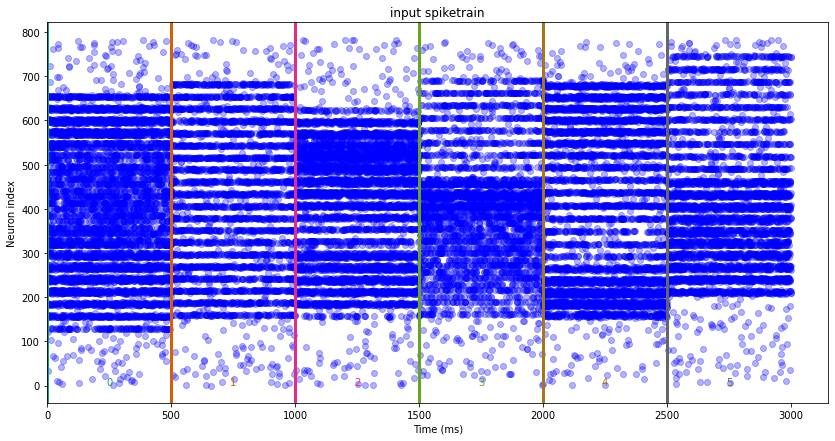

In [7]:
plot_spiketrain(input_layer, len(stimuli))

By integrating all the spikes during an interval of time, and reshaping to the original input shape, we can reconstruct the input images as perceived by the network. Play with the following sliders to see how the input looks like within different time ranges.

In [8]:
interact(lambda start, stop: reconstruct_image(input_layer,
                                               input_shape, [start, stop]),
         start = widgets.IntSlider(min=0, max=sim.get_current_time(), step=20, value=0),
         stop = widgets.IntSlider(min=0, max=sim.get_current_time(), step=20, value=stim_exposure))

interactive(children=(IntSlider(value=0, description='start', max=3000, step=20), IntSlider(value=500, descrip…

<function __main__.<lambda>(start, stop)>

## Output spiketrain

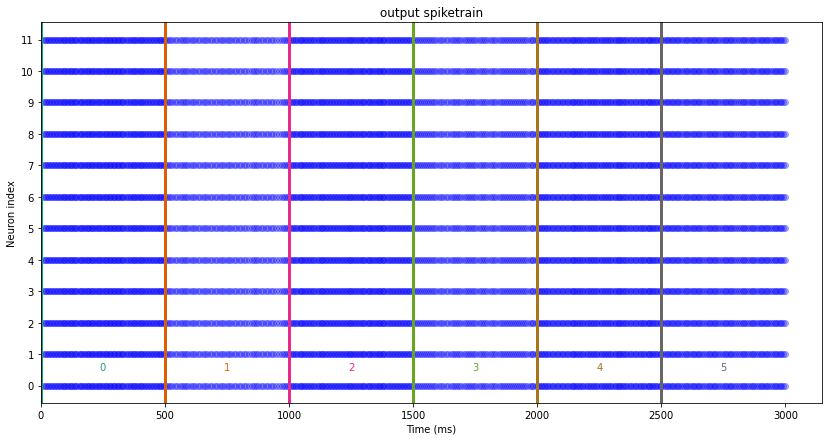

In [9]:
plot_spiketrain(output_layer, len(stimuli))


---------------------------

# Exercise 1 - Fix the projection

All the output neurons have the same spiketrain! What is going on?
If all the output spikes are the exact same, we will learn the same features with all neurons.
We need to introduce some variability in the output spiketrains.
Try to fix it in the following notebook cell by changing the Projection.

Hints:
* http://neuralensemble.org/docs/PyNN/connections.html
* http://neuralensemble.org/docs/PyNN/reference/connectors.html

If you don't have a clue, you can use use the __plot_weights()__ function to get some insights.

In [10]:
input_layer, output_layer = create_network(input_shape, 10)
initial_weights = # Complete here...
synapses = sim.Projection(input_layer, output_layer,
                          sim.AllToAllConnector(),
                          sim.StaticSynapse(weight=initial_weights))
simulate_network(stimuli, input_layer)
plot_spiketrain(output_layer, len(stimuli))

SyntaxError: invalid syntax (<ipython-input-10-36389a95fb0e>, line 2)

# Exercise 2 - Learning features

Until now, our synapses were still static.
Now, we will make them plastic and start learning.
Let's plot the current weights of output neurons:

In [ ]:
plot_weights(synapses)

Do these weights looks like meaningful features?
Not really. Let's try to learn better ones with STDP.
Change the synapse type of the projection from StaticSynapse to STDPMechanism.
I recommend you use a Hebbian-type learning rule, where the synaptic weight increases regardless of whether pre-synaptic neuron or post-synaptic neuron increased.

Hint: http://neuralensemble.org/docs/PyNN/reference/plasticitymodels.html

You can also try to do many epochs by running the __simulate_network()__ in a loop.

--------------

If you get the error:

```bash    
BadProperty in Connect_g_g_D_D: Weight and Wmax must have same sign
```

This means that you have some negative weights in your initial weight distribution. 
Sadly, NEST does not support weights dropping below 0 during STDP. 
Therefore, make sure that your initial_weight distribution contains only positiv numbers.
Different possibilities:
* You can change the distribution you use 
* You can add inhibitory synapses on top of the excitatory ones, to compensate
* You can get/set the weights with a numpy array with:
    
```python
w = synapses.get('weight')
synapses.set(weight=w)
```

with __w__ being a weight matrix.

In [ ]:
input_layer, output_layer = create_network(input_shape, 120)

stdp_model = # Complete here...

synapses = sim.Projection(input_layer, output_layer, # ... and here
                         )


simulate_network(stimuli, input_layer)
plot_spiketrain(output_layer, len(stimuli))
plot_weights(synapses)

# Exercise 3 - Multiple epochs

To learn features, it is preferrable to have a low learning rate and show the dataset multiple times to the network. Run the simulation multiple times on the dataset and observe the weight changes after each epoch.

In [ ]:
n_epoch = 5

# Complete here: network here

figs = []
for i in range(n_epoch):
    simulate_network(stimuli, input_layer)
    figs.append(plot_weights(plastic_synapses_exc, animated=True))

weight_anim = animation.FuncAnimation(figs[0]['figure'], 
                                      create_weight_updates(figs), 
                                      interval=500,
                                      frames=n_epoch,
                                      blit=True)

HTML(weight_anim.to_html5_video())

# Exercise 4 - Learning discriminative features

Do the weights look like something meaningful? 
If all the weights seem to be a "combination" of all the digits at once, we say that the features are not __discriminative__.
Indeed, when a digit is presented and the initial weights of an output neurons are high enough to make this neuron spike (natural bias, or preference), this neuron will be better at detecting this digit thanks to STDP.
However, when another digit is presented, if the same neuron also has a natural bias for this other digit, then it will learn to detect this digit too.
Therefore, its weights will be a combination of the digits it knows.

To prevent this from happening, a common technique is to use lateral inhibition, to implement a __winner-take-all__. 
The idea is, when an output neuron spike because of a natural bias to a digit, it will inhibit the other output neurons, preventing them to learn the same number.
Lateral inhibition is a connection from a layer to itself, with all the weights being some constant, except for the self connection which is 0 (the neuron does not inhibit itself).

Add a lateral inhibition on the output layer and plot the weights again.

In [ ]:
def lateral_inhib(output_layer, weight):
    n_output_neurons = len(output_layer)
    lateral_inhib = sim.Projection(output_layer, output_layer,
                                   sim.AllToAllConnector(allow_self_connections=False),
                                   sim.StaticSynapse(weight=weight, delay=0.1),
                                   receptor_type='inhibitory'
                                  )

# Going further

You can continue playing with the unsupervised learning of features.
* What if you add a random hidden layer? 
* What if you change the STDP parameters?
* What if you add noise to the network, in the form of a Poisson generator connecting to all output neurons?
* What if use a distribution for the dendritic delays in the input/output connection?
* What about different input images?

You can also try to change the learning algorithm to a supervised one, with __associative learning__.
Until now, there is no way to say what output neuron will learn what digit.
With associative learning, you can have a teaching neuron which forces an output neuron to spike at a given frequency when a given digit is presented.